In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.ticker as ticker 
import random
import numpy as np
import pandas as pd
import requests
import lxml.html as lh
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Part One - Import of Missouri Farm Acreage Data
From the university of Missouri's Extension service, we can retrieve the per Acre price on a (mostly)  year basis.

In [3]:
url='https://extension2.missouri.edu/G403'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')
tr_elements = doc.xpath('//tr')
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))

#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 3, the //tr data is not from our table 
    '''if len(T)!=3:
        print("Length of T mismatch")
        break'''
#i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        #Check if row is empty
        #if i>0:
        #Convert any numerical value to integers
            #try:
             #   data=int(data)
            #except:
             #   None
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

#Convert List of tuples (with lists) into a dict and then into a dataframe
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

In [4]:
df['County']=np.where(df.County=='Missouriaverage','State Avg',df.County)

In [5]:
df.rename(columns={'1997b':'1997'},inplace=True)
variables_list=df.columns[1:]
variables_list

Index(['1959', '1964', '1969', '1974', '1978', '1982', '1987', '1992', '1997',
       '2002', '2007', '2012', '2017'],
      dtype='object')

In [6]:
for v in variables_list:
    df[v].replace(to_replace='[^0-9]+', value='',inplace=True,regex=True)
    df=df.astype({v:'int64'})

In [7]:
dfWide=df
dfWide=pd.melt(dfWide,id_vars=['County'],value_vars=variables_list, var_name='Year',value_name='AcrePrice')
dfWide=dfWide.sort_values(by=['County','Year'])
dfWide['Pct_Chg']=dfWide.groupby('County')['AcrePrice'].apply(lambda x: (x-x.shift(1))/x)
dfWide=pd.merge(dfWide,dfWide[dfWide.County=='State Avg'][['Year','AcrePrice']], on = 'Year', how='left')
dfWide['Price Diff From Avg']=dfWide.AcrePrice_x-dfWide.AcrePrice_y
dfWide.rename(columns={'AcrePrice_x':'AcrePrice'}, inplace = True)
dfWide.drop(columns='AcrePrice_y', inplace = True)
dfWide=pd.merge(dfWide,dfWide[dfWide.County=='State Avg'][['Year','Pct_Chg']], on = 'Year', how='left')
dfWide['Pct Chg Diff From Avg']=dfWide.Pct_Chg_x-dfWide.Pct_Chg_y
dfWide.rename(columns={'Pct_Chg_x':'Pct_Chg'}, inplace = True)
dfWide.drop(columns='Pct_Chg_y', inplace = True)
dfWide.head(10)

,County,Year,AcrePrice,Pct_Chg,Price Diff From Avg,Pct Chg Diff From Avg
0,Adair,1959,115,NaN,3,NaN
1,Adair,1964,118,0.025424,-32,-0.227910
2,Adair,1969,168,0.297619,-56,-0.032738
3,Adair,1974,299,0.438127,-97,0.003784
4,Adair,1978,511,0.414873,-212,-0.037409
5,Adair,1982,635,0.195276,-221,0.039902
6,Adair,1987,418,-0.519139,-222,-0.181639
7,Adair,1992,454,0.079295,-320,-0.093831
8,Adair,1997,650,0.301538,-419,0.025580
9,Adair,2002,1012,0.357708,-496,0.066593


# Retrieve the regional codes for each MO County
From the Missouri Census Data Center we retrieve regional groupings and attach them to our dataset. This will allow for the meaningful aggregation of 100+ Counties into ~12 regional groups.

In [8]:
url='https://mcdc.missouri.edu/geography/reference/MO_Region_Codes.html'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')[14:]
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))

#Since our first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 3, the //tr data is not from our table 
    '''if len(T)!=3:
        print("Length of T mismatch")
        break'''
#i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        #Check if row is empty
        #if i>0:
        #Convert any numerical value to integers
            #try:
             #   data=int(data)
            #except:
             #   None
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

#Convert List of tuples (with lists) into a dict and then into a dataframe
Dict={title:column for (title,column) in col}
df2=pd.DataFrame(Dict)

In [9]:
dfWide2=pd.merge(dfWide,df2, left_on='County', right_on='county', how='left')
dfWide2.drop(columns='county',inplace=True)
dfWide2

,County,Year,AcrePrice,Pct_Chg,Price Diff From Avg,Pct Chg Diff From Avg,Fipco,Region
0,Adair,1959,115,NaN,3,NaN,29001,Northeast
1,Adair,1964,118,0.025424,-32,-0.227910,29001,Northeast
2,Adair,1969,168,0.297619,-56,-0.032738,29001,Northeast
3,Adair,1974,299,0.438127,-97,0.003784,29001,Northeast
4,Adair,1978,511,0.414873,-212,-0.037409,29001,Northeast
...,...,...,...,...,...,...,...,...
1490,Wright,1997,881,0.257662,-188,-0.018297,29229,South Central
1491,Wright,2002,1259,0.300238,-249,0.009124,29229,South Central
1492,Wright,2007,1811,0.304804,-368,-0.003135,29229,South Central
1493,Wright,2012,1797,-0.007791,-994,-0.227067,29229,South Central


# Begin Vizualizations
1. Show the table
2. Show the Acre Price over time by county for each region
3. Show the Acre Price Difference with respect to Missouri's Average Price
4. Show the Acre Price Change over time by county for each region
5. Show the Acre Price Change Over Time With Respect to Missouri's Average Price Price change over time.


In [10]:
dfWide2['Region']=np.where(pd.isnull(dfWide2['Region']),'Avg',dfWide2['Region'])
dfWide2

,County,Year,AcrePrice,Pct_Chg,Price Diff From Avg,Pct Chg Diff From Avg,Fipco,Region
0,Adair,1959,115,NaN,3,NaN,29001,Northeast
1,Adair,1964,118,0.025424,-32,-0.227910,29001,Northeast
2,Adair,1969,168,0.297619,-56,-0.032738,29001,Northeast
3,Adair,1974,299,0.438127,-97,0.003784,29001,Northeast
4,Adair,1978,511,0.414873,-212,-0.037409,29001,Northeast
...,...,...,...,...,...,...,...,...
1490,Wright,1997,881,0.257662,-188,-0.018297,29229,South Central
1491,Wright,2002,1259,0.300238,-249,0.009124,29229,South Central
1492,Wright,2007,1811,0.304804,-368,-0.003135,29229,South Central
1493,Wright,2012,1797,-0.007791,-994,-0.227067,29229,South Central


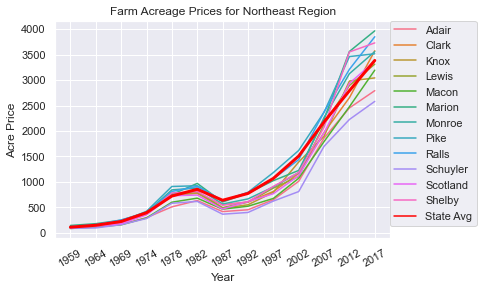

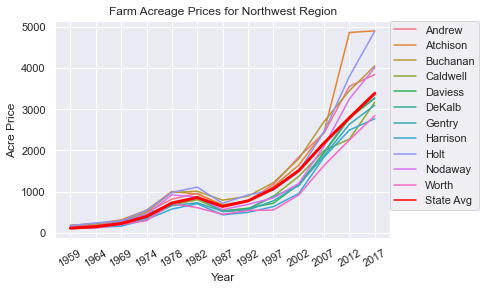

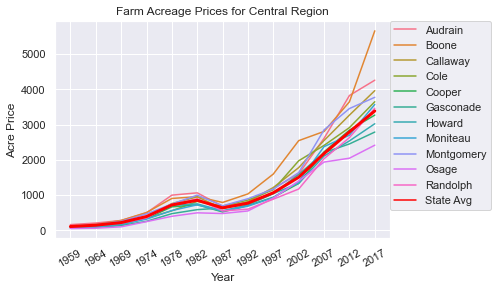

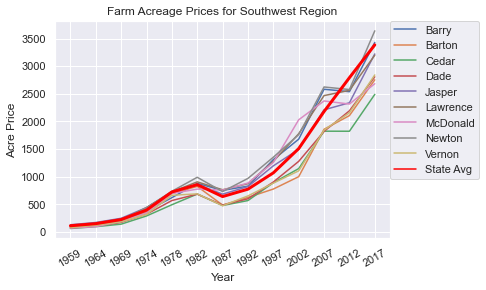

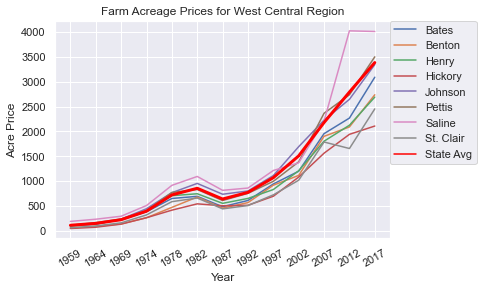

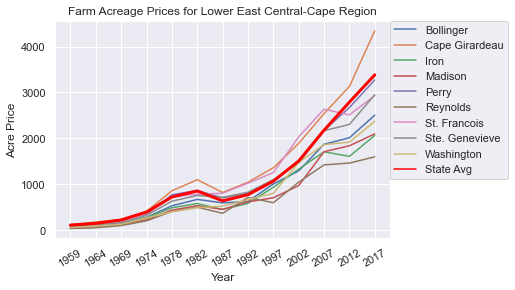

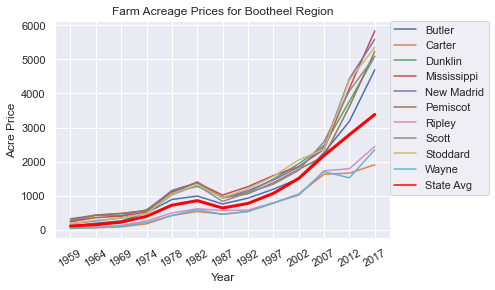

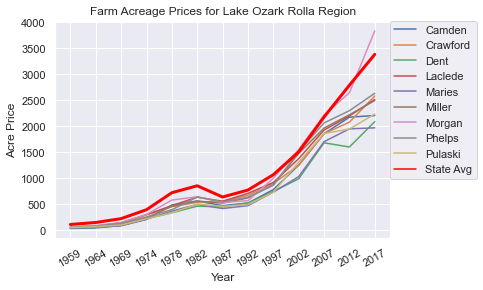

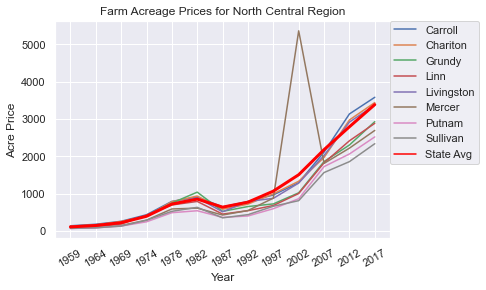

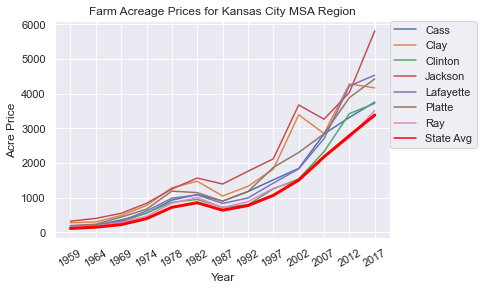

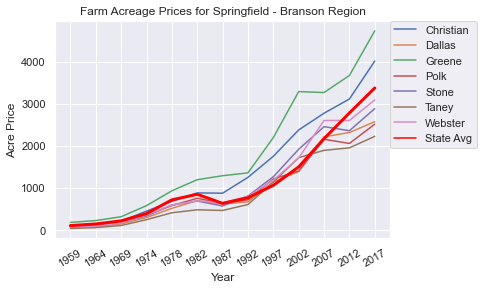

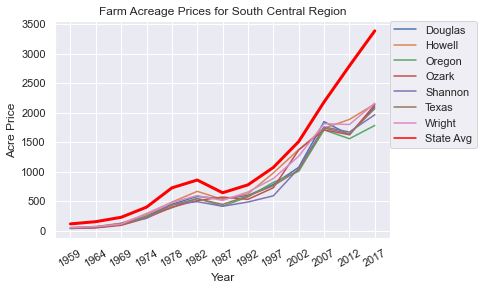

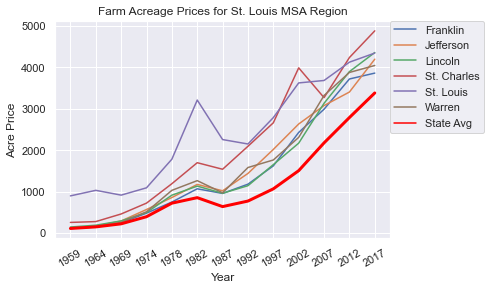

In [11]:
for v in dfWide2[dfWide2.Region != 'Avg']['Region'].unique():
    dfPlot=dfWide2[dfWide2.Region==v]
    sns.set_theme(style="darkgrid")
    g=sns.lineplot(x = "Year", y = "AcrePrice", hue="County", data = dfPlot)
    g.set_xticklabels(labels=dfPlot.Year.unique(),rotation=30)
    g.set_ylabel('Acre Price')
    g.set(title='Farm Acreage Prices for {} Region'.format(v))
    e=sns.lineplot(x = "Year", y = "AcrePrice", hue="County", data = dfWide2[dfWide2.County=='State Avg'], linewidth = 3, palette=['red'])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)
    plt.show()

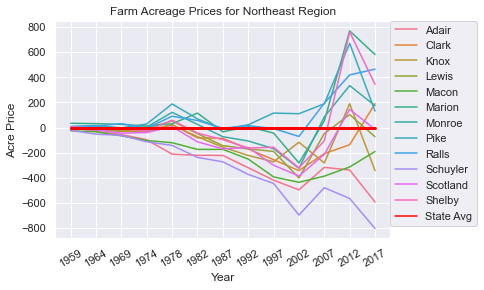

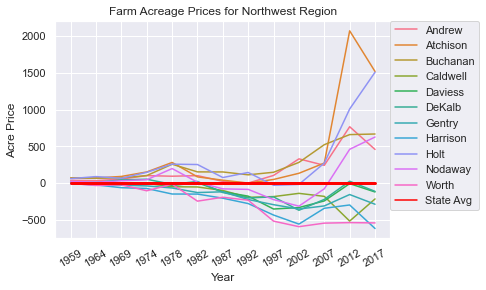

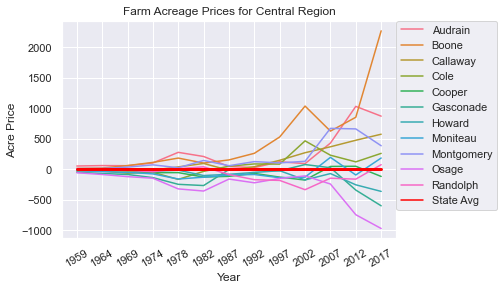

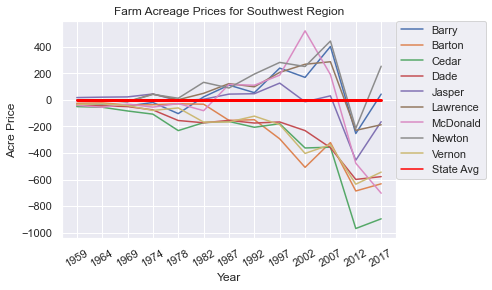

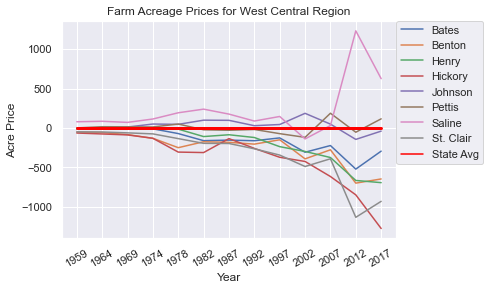

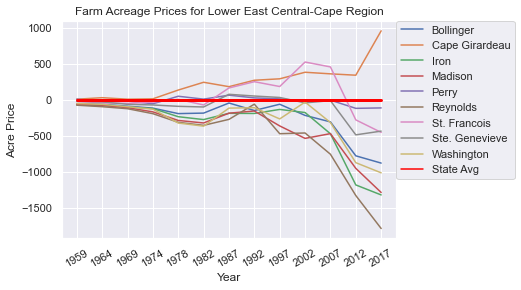

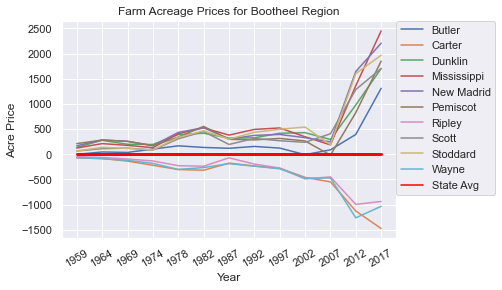

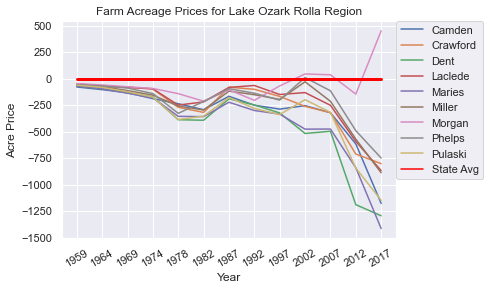

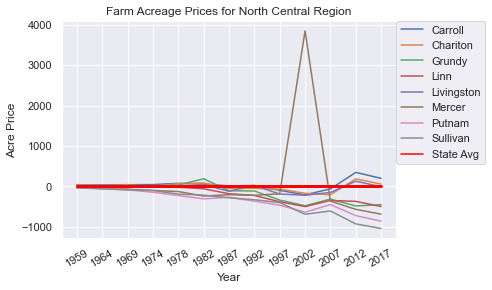

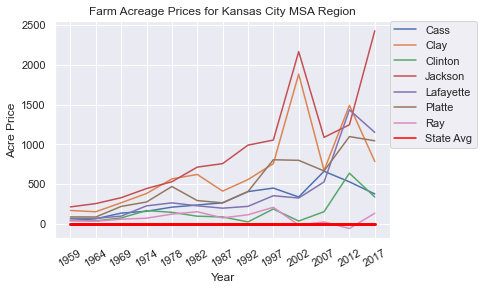

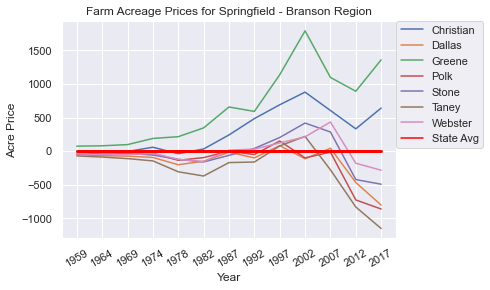

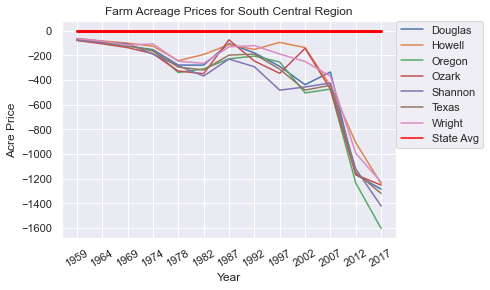

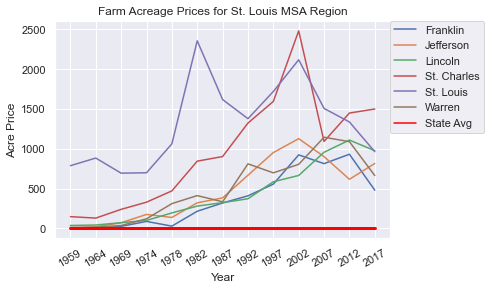

In [12]:
for v in dfWide2[dfWide2.Region != 'Avg']['Region'].unique():
    dfPlot=dfWide2[dfWide2.Region==v]
    sns.set_theme(style="darkgrid")
    g=sns.lineplot(x = "Year", y = "Price Diff From Avg", hue="County", data = dfPlot)
    g.set_xticklabels(labels=dfPlot.Year.unique(),rotation=30)
    g.set_ylabel('Acre Price')
    g.set(title='Farm Acreage Prices for {} Region'.format(v))
    e=sns.lineplot(x = "Year", y = "Price Diff From Avg", hue="County", data = dfWide2[dfWide2.County=='State Avg'], linewidth = 3, palette=['red'])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)
    plt.show()

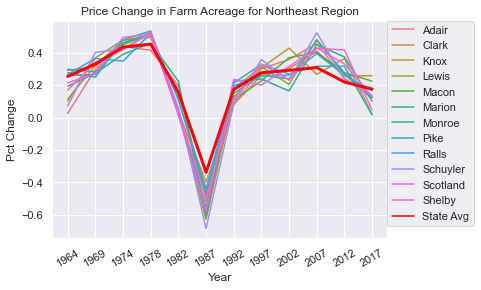

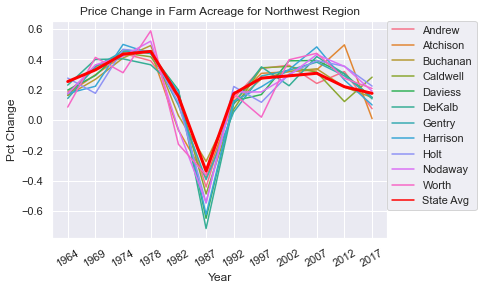

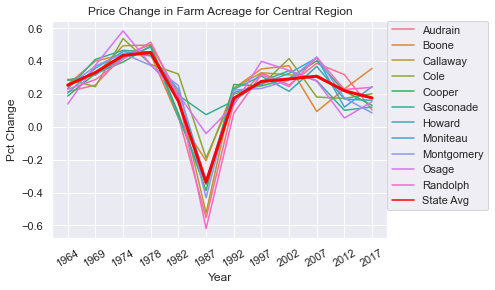

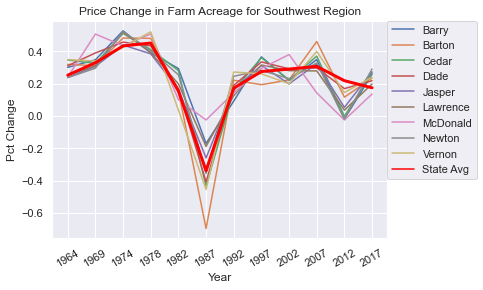

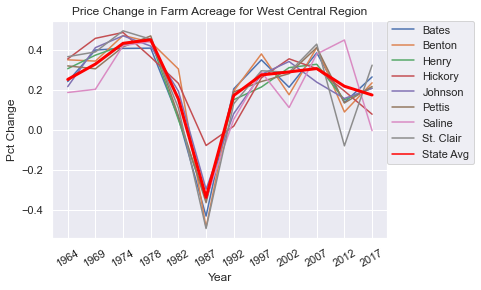

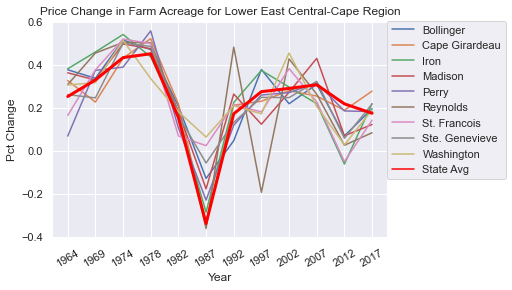

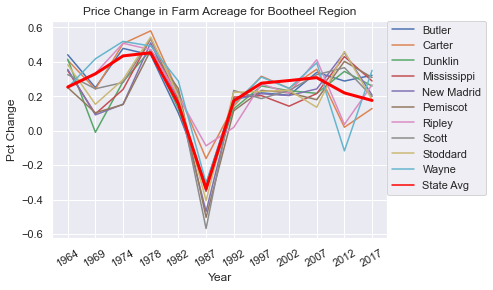

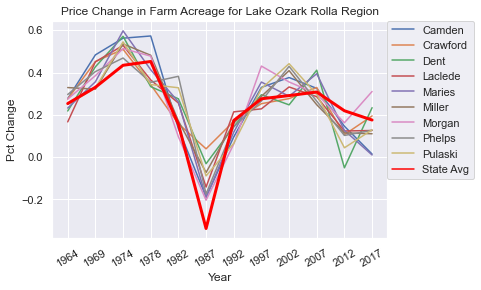

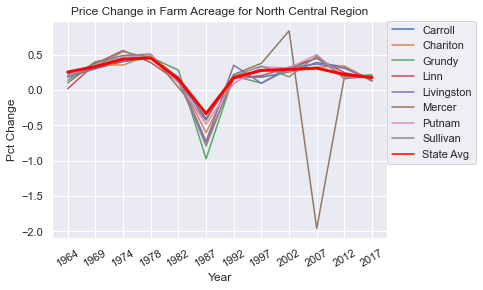

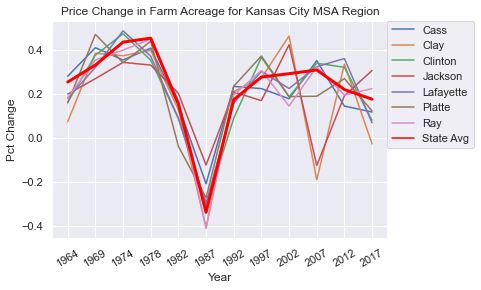

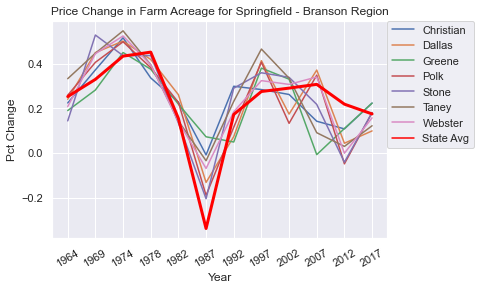

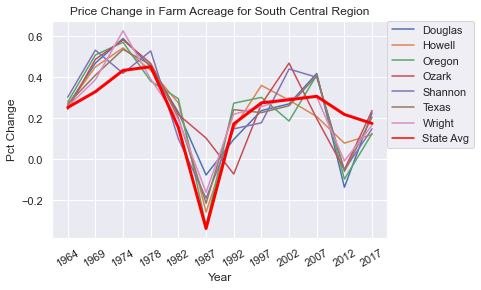

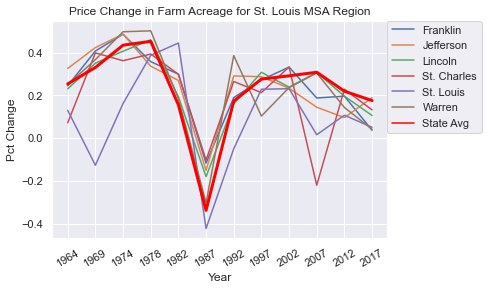

In [13]:
for v in dfWide2[dfWide2.Region != 'Avg']['Region'].unique():
    dfPlot=dfWide2[dfWide2.Region==v]
    sns.set_theme(style="darkgrid")
    g=sns.lineplot(x = "Year", y = "Pct_Chg", hue="County", data = dfPlot)
    g.set_xticklabels(labels=dfPlot.Year.unique(),rotation=30)
    g.set_ylabel('Pct Change')
    g.set(title='Price Change in Farm Acreage for {} Region'.format(v))
    e=sns.lineplot(x = "Year", y = "Pct_Chg", hue="County", data = dfWide2[dfWide2.County=='State Avg'], linewidth = 3, palette=['red'])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)
    plt.show()

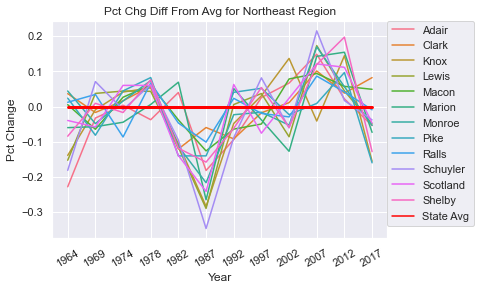

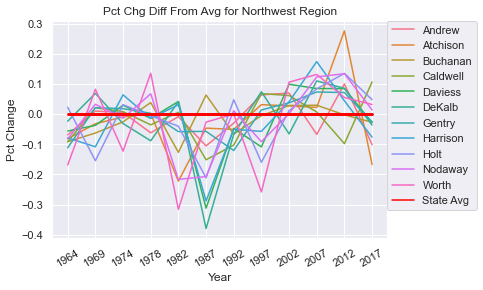

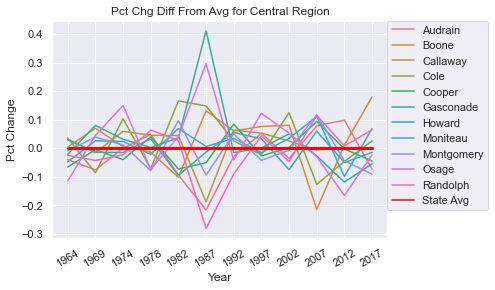

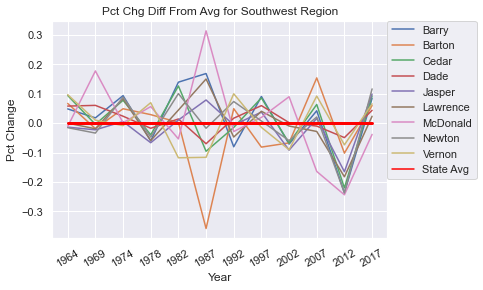

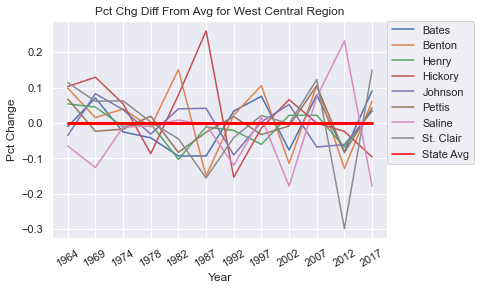

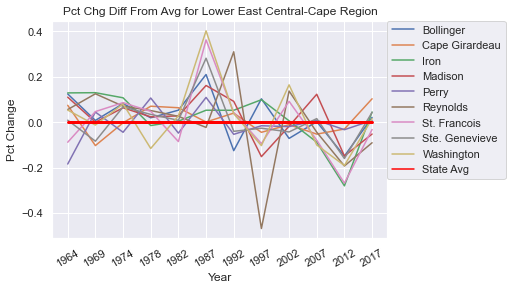

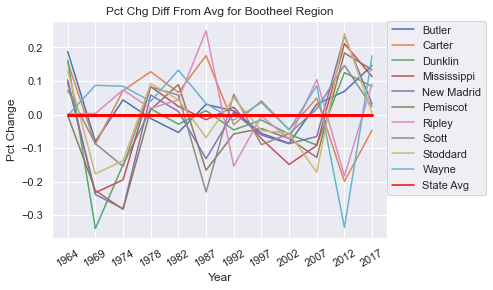

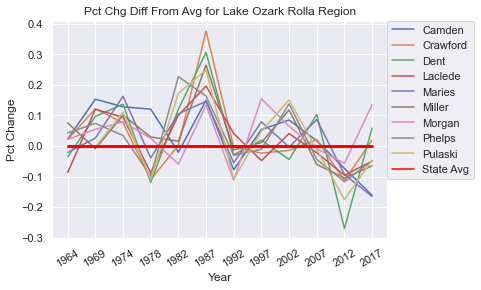

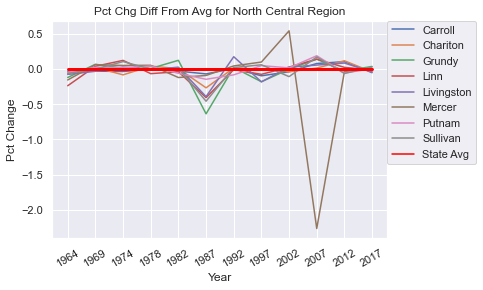

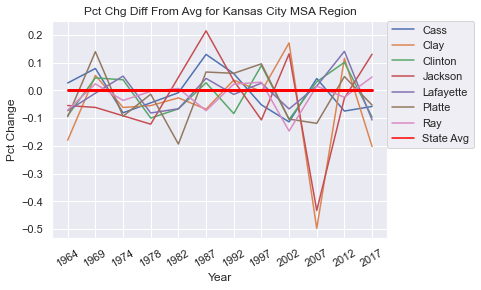

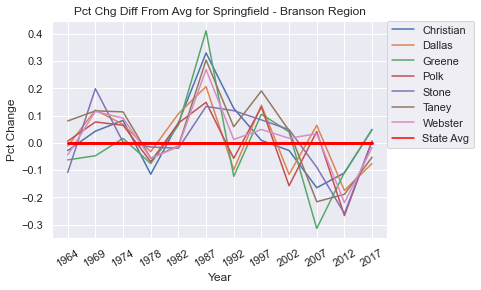

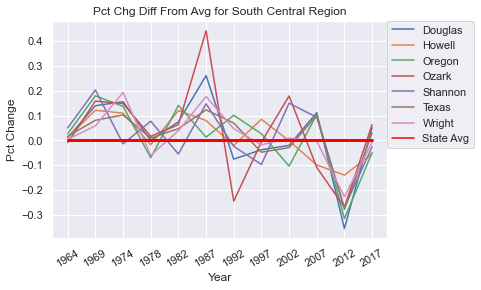

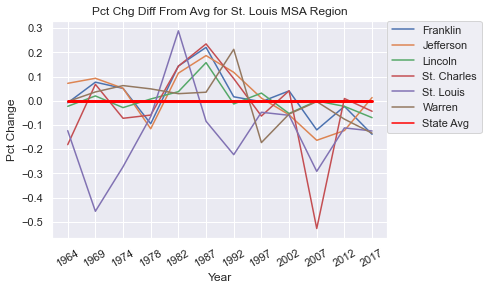

In [14]:
for v in dfWide2[dfWide2.Region != 'Avg']['Region'].unique():
    dfPlot=dfWide2[dfWide2.Region==v]
    sns.set_theme(style="darkgrid")
    g=sns.lineplot(x = "Year", y = "Pct Chg Diff From Avg", hue="County", data = dfPlot)
    g.set_xticklabels(labels=dfPlot.Year.unique(),rotation=30)
    g.set_ylabel('Pct Change')
    g.set(title='Pct Chg Diff From Avg for {} Region'.format(v))
    e=sns.lineplot(x = "Year", y = "Pct Chg Diff From Avg", hue="County", data = dfWide2[dfWide2.County=='State Avg'], linewidth = 3, palette=['red'])
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)
    plt.show()